In [1]:
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from textblob import TextBlob
#from wordcloud import WordCloud
from string import digits
import pandas as pd
import string
import seaborn as sns
import re, spacy, gensim
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint

In [2]:
nltk.download("stopwords")
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1998a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1998a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
csv_path = "data/BA_reviews.csv"
df = pd.read_csv(csv_path)
df.reset_index(drop=True, inplace=True)

print(df['reviews'])

0      ✅ Trip Verified |  We started our day with BA ...
1      ✅ Trip Verified |  I fly British Airways weekl...
2      Not Verified |  Everything was ok until our co...
3      Not Verified |  My initial flight was cancelle...
4      Not Verified |  We will never fly British Airw...
                             ...                        
995    ✅ Trip Verified |  Manchester to London. The b...
996    ✅ Trip Verified |  San Diego to Hannover via L...
997    ✅ Trip Verified |  London Heathrow to Stuttgar...
998    ✅ Trip Verified |  London to Johannesburg. Tur...
999    ✅ Trip Verified |  Having booked BA Business C...
Name: reviews, Length: 1000, dtype: object


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   reviews     1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


,Unnamed: 0
count,1000.000000
mean,499.500000
std,288.819436
min,0.000000
25%,249.750000
50%,499.500000
75%,749.250000
max,999.000000


In [5]:
df['reviews'] = df['reviews'].str.strip()
df['reviews']=df['reviews'].str.lstrip('✅ Trip Verified |')
df['reviews']=df['reviews'].str.lstrip('Not Verified |')
df['reviews']= df['reviews'].str.lower()
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '')  # Remove punctuation
print(df)

     Unnamed: 0                                            reviews
0             0  we started our day with ba in prague. the flig...
1             1  i fly british airways weekly not because i wan...
2             2  everything was ok until our connecting flight ...
3             3  my initial flight was cancelled 8 hours prior ...
4             4  we will never fly british airways again. our f...
..          ...                                                ...
995         995  manchester to london. the bag drop process too...
996         996  san diego to hannover via london. i booked on ...
997         997  london heathrow to stuttgart. absolutely disgu...
998         998  london to johannesburg. turning right to the f...
999         999  having booked ba business class and paid extra...

[1000 rows x 2 columns]


## Tokenization

In [6]:
data = df.reviews.values.tolist()
# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]
print(data[:1])

['we started our day with ba in prague. the flight actually left on time! i came to find out that’s very unusual. we purchased business class seats. as you can see from the picture they hardly were business class. all they did was block off the middle seat in the first few rows and called it business class. horrible flight. in addition i had a really rude rude check in clerk basically yell at me when i excused myself and asked if she could give a little bit of priority to the many business class passengers who weren’t being served. then we got to heathrow and the real fun began. we had a 4 hour delay. they gave us about 5 different excuses for the delay. i had a few employees walk away while i was asking them questions. they were very rude. at one point there were no employees left. and from the announcements it seems virtually every ba flight was delayed. and there were no weather issues. there was no place to comfortably store items in business class. i’ve never experienced that befo

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc true removes punctuation

data_words = list(sent_to_words(df['reviews'].tolist()))

print(data_words[:1])

[['we', 'started', 'our', 'day', 'with', 'ba', 'in', 'prague', 'the', 'flight', 'actually', 'left', 'on', 'time', 'came', 'to', 'find', 'out', 'that', 'very', 'unusual', 'we', 'purchased', 'business', 'class', 'seats', 'as', 'you', 'can', 'see', 'from', 'the', 'picture', 'they', 'hardly', 'were', 'business', 'class', 'all', 'they', 'did', 'was', 'block', 'off', 'the', 'middle', 'seat', 'in', 'the', 'first', 'few', 'rows', 'and', 'called', 'it', 'business', 'class', 'horrible', 'flight', 'in', 'addition', 'had', 'really', 'rude', 'rude', 'check', 'in', 'clerk', 'basically', 'yell', 'at', 'me', 'when', 'excused', 'myself', 'and', 'asked', 'if', 'she', 'could', 'give', 'little', 'bit', 'of', 'priority', 'to', 'the', 'many', 'business', 'class', 'passengers', 'who', 'weren', 'being', 'served', 'then', 'we', 'got', 'to', 'heathrow', 'and', 'the', 'real', 'fun', 'began', 'we', 'had', 'hour', 'delay', 'they', 'gave', 'us', 'about', 'different', 'excuses', 'for', 'the', 'delay', 'had', 'few', 

## Stemming

In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [9]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']) #select noun and verb
print(data_lemmatized[:2])

['start day flight actually leave time come find very unusual purchase business class seat see picture hardly business class block middle seat first few row call business class horrible flight addition really rude rude check clerk basically yell excuse ask give little bit priority many business class passenger weren serve then get heathrow real fun begin hour delay give different excuse delay few employee walk away ask question very rude point employee leave announcement seem virtually ba flight delay weather issue place comfortably store item business class ve never experience even cup holder bottle water seat control work keep push button get power outlet work internet entire flight bin too heavy almost get hernia have close horrible airline never fly again give star', 'fly weekly want own route there other option therefore frankly care customer flight always delay always else fault weather delay incoming aircraft flight traffic control issue ve hear life understand allow operate ve 

## Document word Matrix

In [10]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                         # minimum reqd occurences of a word 
                             stop_words='english',              # remove stop words
                             lowercase=True,                    # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'   # num chars > 3
                                                                # max_features=50000,             
                                                                # max number of uniq words    
                                                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

## LDA Modelling

In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=5,                # Number of topics
                                      max_iter=10,                    # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,               # Random state
                                      batch_size=128,                 # n docs in each learning iter
                                      evaluate_every = -1,            # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,                    # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=100)


## Dominant Topic

In [12]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)
# column names
topicnames = ['Topic' + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.120000,0.330000,0.000000,0.000000,0.550000,4
Doc1,0.180000,0.800000,0.000000,0.000000,0.000000,1
Doc2,0.350000,0.000000,0.650000,0.000000,0.000000,2
Doc3,0.570000,0.000000,0.340000,0.090000,0.000000,0
Doc4,0.950000,0.010000,0.010000,0.010000,0.010000,0
Doc5,0.000000,0.000000,0.000000,0.000000,0.980000,4
Doc6,0.480000,0.010000,0.480000,0.010000,0.010000,0
Doc7,0.250000,0.000000,0.740000,0.000000,0.000000,2
Doc8,0.720000,0.000000,0.280000,0.000000,0.000000,0
Doc9,0.010000,0.010000,0.010000,0.070000,0.910000,4


In [13]:
df_document_topic.shape

(1000, 6)

In [14]:
topics_ = df_document_topic['dominant_topic'].tolist()

In [15]:
df['topic'] = topics_

In [16]:
df.head()

,Unnamed: 0,reviews,topic
0,0,we started our day with ba in prague. the flig...,4
1,1,i fly british airways weekly not because i wan...,1
2,2,everything was ok until our connecting flight ...,2
3,3,my initial flight was cancelled 8 hours prior ...,0
4,4,we will never fly british airways again. our f...,0


In [23]:
df_document_topic[df_document_topic['topic'] == 1].groupby(['topic'])['sentiment'].value_counts().unstack().plot.bar(stacked=True)


KeyError: 'topic'

In [20]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -286565.2195626569
Perplexity:  418.3771080098504
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,527
1,0,217
2,2,149
3,1,91
4,3,16


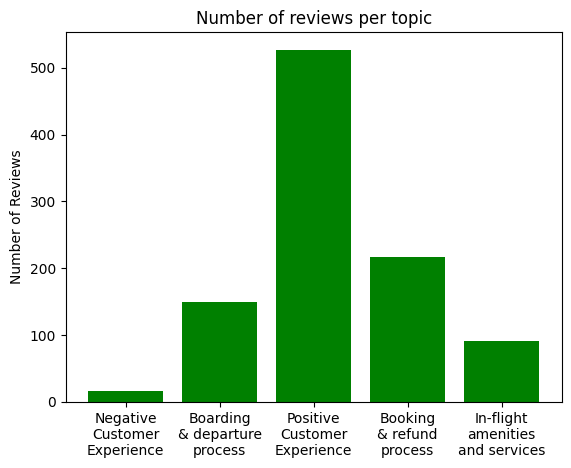

In [22]:
plt.bar(range(1,6,1),[16,149, 527, 217,91], color="green")
plt.ylabel("Number of Reviews")
plt.title("Number of reviews per topic")
x_labels = ([ "Negative\nCustomer\nExperience", "Boarding\n& departure\nprocess", 
            "Positive\nCustomer\nExperience", "Booking\n& refund\nprocess", "In-flight\namenities\nand services"])
plt.xticks(range(1,6), x_labels)
# Show the graph
plt.show()


In [27]:
# Topic-Keyword Matrix

# Assign Column and Index
feature_names = vectorizer.get_feature_names_out()
df_topic_keywords = pd.DataFrame(lda_model.components_, columns=feature_names)
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,able,absolute,absolutely,accept,acceptable,access,accommodation,account,act,actually,...,word,work,world,worth,wouldn,write,wrong,year,yesterday,young
Topic0,13.168502,0.277998,9.531793,27.985879,0.462049,6.353182,9.482978,0.320202,3.758561,13.410668,...,5.292025,32.467213,4.408445,3.993859,8.488350,2.324714,14.675136,34.823408,1.726654,0.208047
Topic1,9.588479,1.182115,19.333480,0.204695,0.214814,0.206227,0.216780,0.225279,0.268027,2.188454,...,4.058163,23.358723,8.835454,0.205931,0.204411,15.823717,0.224948,48.787809,2.467375,11.134754
Topic2,38.179815,3.429229,5.725824,1.039573,2.159825,0.256014,6.352100,12.697802,3.875025,4.164700,...,0.663751,20.409217,4.039216,2.418655,6.527573,7.310986,16.796595,13.673506,6.872311,0.207323
Topic3,0.261883,8.111434,0.369054,0.219429,0.202229,0.203633,0.615323,0.203042,0.201647,0.204418,...,0.203755,0.311221,0.210807,0.223415,0.205723,0.243657,0.354912,0.207042,0.227468,0.202792
Topic4,11.279287,0.481206,0.954512,7.557471,15.917105,22.808430,0.211399,1.562369,4.189944,25.070692,...,3.732626,106.576690,96.342932,35.224483,0.242850,4.043185,3.582207,49.787170,0.364745,7.234138


In [29]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,flight,cancel,book,customer,refund,seat,pay,service,hour,day,ticket,fly,return,change,time
Topic 1,staff,flight,service,fly,airline,time,ask,check,thank,customer,year,heathrow,help,crew,travel
Topic 2,flight,hour,check,tell,airline,airport,say,delay,time,service,plane,wait,arrive,day,just
Topic 3,bag,luggage,baggage,lose,arrive,day,claim,suitcase,deliver,make,file,send,hotel,late,tag
Topic 4,flight,seat,good,food,crew,cabin,service,class,time,business,economy,drink,meal,fly,passenger


In [50]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5b/6f/8b125d126d54061c0be610b135aaf2f8960f55c2e185ac32445e4a5012d5/tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/38/ba/dd4d998a852451e98dc009ecb208bbb0eeb0c8252dc35b7c4e1050762b36/tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.w

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\BritishAirway-Data-Analysis\\venv\\Lib\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [51]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [25]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

## Stop words removals

In [45]:
df['tokens'] = data_words

In [46]:
stop_words = set(stopwords.words('english'))


df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

## Sentiment Analysis

In [33]:
# Define a function to get sentiment polarity

def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'reviews' column
df['sentiment_polarity'] = df['reviews'].apply(get_sentiment_polarity)

## Word Frequency

In [47]:
from collections import Counter

# Count word frequencies
word_frequencies = Counter(df['tokens'].sum())

# Print the most common words
print(word_frequencies.most_common(10))

[('flight', 1883), ('ba', 1181), ('service', 707), ('london', 590), ('seat', 498), ('time', 485), ('food', 453), ('crew', 447), ('one', 424), ('class', 422)]


In [53]:
df['sentiment'].value_counts()

sentiment
positive    485
negative    483
neutral      32
Name: count, dtype: int64

<Axes: xlabel='topic'>

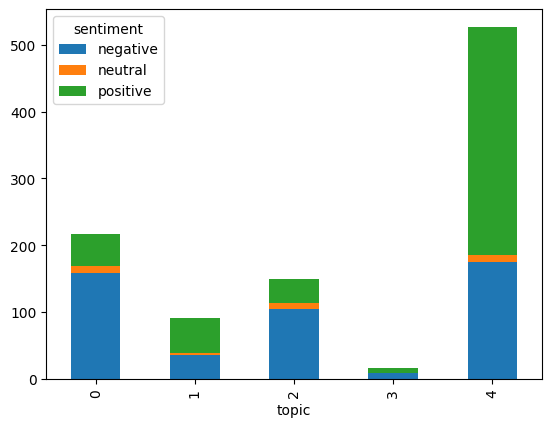

In [54]:
df.groupby('topic')['sentiment'].value_counts().unstack().plot.bar(stacked=True)

In [55]:
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import FreqDist

In [57]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1998a\AppData\Roaming\nltk_data...


True

In [58]:
import string
from nltk.corpus import stopwords

# Convert to lower case
df['review_text'] = df['reviews'].str.lower()

# Remove punctuation and numbers
df['review_text'] = df['review_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation + string.digits)))

# Remove stop words
stop_words = stopwords.words("english")
stop_words.extend(['british','airway','airline','ba','flight'])
stop_words = set(stop_words)
df['review_text'] = df['review_text'].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in stop_words))


# Perform lemmatization 
lemmatizer = WordNetLemmatizer()
df['review_text'] = df['review_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) 
                                                                    for word in x.split() if len(word)> 3]))

In [59]:
# Get bigrams and their frequency
bigrams = list(ngrams(df[df['sentiment'] == 'POSITIVE']['review_text'].str.cat(sep=' ').split(), 2))
bigrams_fd = FreqDist(bigrams)

In [60]:
bigrams_fd = {'_'.join(bigram): freq for bigram, freq in bigrams_fd.items()}

## Sentiment Analysis with VADER

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
df['sentiment_scores'] = df['reviews'].apply(lambda review: sid.polarity_scores(review))

# Classify each review as positive, negative, or neutral based on the compound score
df['sentiment'] = df['sentiment_scores'].apply(lambda score: 'positive' if score['compound'] > 0.1 else ('negative' if score['compound'] < -0.1 else 'neutral'))

# Print the sentiment analysis results
print(df[['reviews', 'sentiment']])

                                               reviews sentiment
0    we started our day with ba in prague. the flig...  negative
1    i fly british airways weekly not because i wan...  negative
2    everything was ok until our connecting flight ...  negative
3    my initial flight was cancelled 8 hours prior ...  negative
4    we will never fly british airways again. our f...  negative
..                                                 ...       ...
995  manchester to london. the bag drop process too...  negative
996  san diego to hannover via london. i booked on ...  negative
997  london heathrow to stuttgart. absolutely disgu...  positive
998  london to johannesburg. turning right to the f...  positive
999  having booked ba business class and paid extra...  negative

[1000 rows x 2 columns]


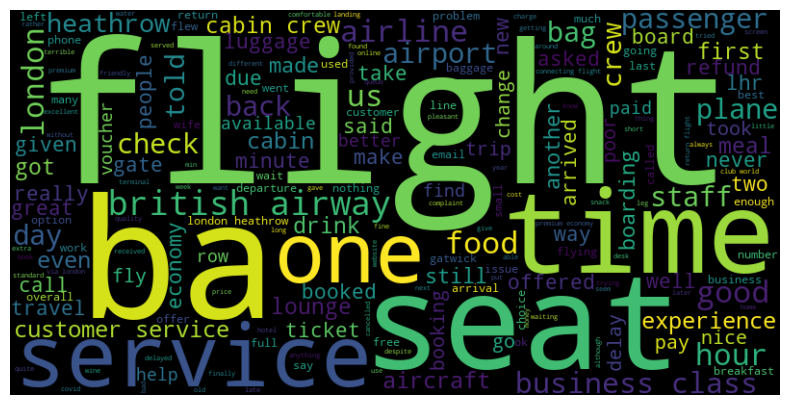

In [48]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all tokens into a single string
all_text = ' '.join(df['tokens'].apply(lambda tokens: ' '.join(tokens)))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Topic Modeling with Latent Dirichlet Allocation (LDA)

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Join tokens back into text
df['cleaned_text'] = df['tokens'].apply(' '.join)

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.85, max_features=1000, stop_words='english')
vectorized_text = vectorizer.fit_transform(df['cleaned_text'])

# Apply Latent Dirichlet Allocation (LDA)
num_topics = 2  # Number of topics to identify
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_output = lda_model.fit_transform(vectorized_text)

# Display the topics and their top words
feature_names = vectorizer.get_feature_names_out()

topic_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
    weights = [topic[i] for i in topic.argsort()[:-5 - 1:-1]]
    topic_words.append({'Topic': topic_idx, 'Top Words': top_words, 'Weights': weights})

df_topics = pd.DataFrame(topic_words)
print(df_topics)

# Assign each review to its dominant topic
df['dominant_topic'] = df['cleaned_text'].apply(lambda x: lda_model.transform(vectorizer.transform([x])).argmax())
print(df[['reviews', 'dominant_topic']])

   Topic                               Top Words  \
0      0       [flight, ba, food, crew, service]   
1      1  [flight, ba, london, british, airways]   

                                             Weights  
0  [834.3212265108708, 533.8707046720523, 444.082...  
1  [1049.6787734891177, 648.1292953279366, 312.50...  
                                               reviews  dominant_topic
0    we started our day with ba in prague. the flig...               0
1    i fly british airways weekly not because i wan...               1
2    everything was ok until our connecting flight ...               1
3    my initial flight was cancelled 8 hours prior ...               1
4    we will never fly british airways again. our f...               1
..                                                 ...             ...
995  manchester to london. the bag drop process too...               0
996  san diego to hannover via london. i booked on ...               1
997  london heathrow to stuttgart. abso

In [31]:
df

,Unnamed: 0,reviews,tokens,sentiment_polarity,sentiment_scores,sentiment,cleaned_text,dominant_topic
0,0,we started our day with ba in prague. the flig...,"[started, day, ba, prague, ., flight, actually...",-0.136780,"{'neg': 0.123, 'neu': 0.849, 'pos': 0.028, 'co...",negative,started day ba prague . flight actually left t...,0
1,1,i fly british airways weekly not because i wan...,"[fly, british, airways, weekly, want, route, ’...",0.059170,"{'neg': 0.144, 'neu': 0.811, 'pos': 0.046, 'co...",negative,fly british airways weekly want route ’ option...,1
2,2,everything was ok until our connecting flight ...,"[everything, ok, connecting, flight, london, ,...",-0.103274,"{'neg': 0.127, 'neu': 0.796, 'pos': 0.077, 'co...",negative,"everything ok connecting flight london , take ...",1
3,3,my initial flight was cancelled 8 hours prior ...,"[initial, flight, cancelled, 8, hours, prior, ...",-0.053022,"{'neg': 0.099, 'neu': 0.872, 'pos': 0.029, 'co...",negative,initial flight cancelled 8 hours prior flight ...,1
4,4,we will never fly british airways again. our f...,"[never, fly, british, airways, ., flight, july...",-0.393333,"{'neg': 0.102, 'neu': 0.874, 'pos': 0.024, 'co...",negative,never fly british airways . flight july 15 202...,1
...,...,...,...,...,...,...,...,...
995,995,manchester to london. the bag drop process too...,"[manchester, london, ., bag, drop, process, to...",-0.102143,"{'neg': 0.128, 'neu': 0.835, 'pos': 0.038, 'co...",negative,manchester london . bag drop process took hour...,0
996,996,san diego to hannover via london. i booked on ...,"[san, diego, hannover, via, london, ., booked,...",0.050000,"{'neg': 0.072, 'neu': 0.915, 'pos': 0.013, 'co...",negative,san diego hannover via london . booked ba.com ...,1
997,997,london heathrow to stuttgart. absolutely disgu...,"[london, heathrow, stuttgart, ., absolutely, d...",-0.205000,"{'neg': 0.105, 'neu': 0.767, 'pos': 0.127, 'co...",positive,london heathrow stuttgart . absolutely disgust...,1
998,998,london to johannesburg. turning right to the f...,"[london, johannesburg, ., turning, right, firs...",0.266750,"{'neg': 0.006, 'neu': 0.783, 'pos': 0.211, 'co...",positive,london johannesburg . turning right first wing...,0
